# Introduction
train and test data are measured with same roll resistance (lever position 3) and wheel pressure.


# Analyze
Question: Which features and model is good enough to be predict virtual power?

_Train data (app data):
* X of app data set -> cadence
* Y -> velocity

## Pre processing


In [3]:
import pandas as pd

from src.tcx import Tcx, COLUMN_NAME_SPEED, COLUMN_NAME_WATTS, COLUMN_NAME_CADENCE
from src.test_data import TrainDataSet

tcx_app: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535177298-gear7.tcx')
tcx_tacx: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')
tcx_tacx_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')

# generate test data
dts_tacx: TrainDataSet = TrainDataSet(tcx_tacx)

def print_stats(df: pd.DataFrame):

    #print(df[['Speed', 'Cadence', 'Ext.Watts', 'DistanceMeters', 'DistanceMeters-delta', 'Ext.Speed', 'Time', 'Time-delta']].head(100))

    # print(df[[COLUMN_NAME_SPEED]].describe())
    print(df.assign(speed_int=lambda x: x[COLUMN_NAME_CADENCE].apply(lambda x : int(x)))
          .groupby(by=['speed_int'])[COLUMN_NAME_WATTS].describe())

print_stats(dts_tacx.get_dataframe())

           count        mean       std    min     25%    50%     75%    max
speed_int                                                                  
63           2.0   72.000000  0.000000   72.0   72.00   72.0   72.00   72.0
64           2.0   73.000000  0.000000   73.0   73.00   73.0   73.00   73.0
65           2.0   74.500000  0.707107   74.0   74.25   74.5   74.75   75.0
66           1.0   77.000000       NaN   77.0   77.00   77.0   77.00   77.0
67           4.0   78.000000  0.816497   77.0   77.75   78.0   78.25   79.0
68           6.0   79.666667  1.211060   78.0   79.00   79.5   80.75   81.0
69           5.0   80.400000  1.949359   77.0   81.00   81.0   81.00   82.0
70           8.0   82.000000  1.511858   80.0   80.75   82.5   83.00   84.0
71          13.0   84.538462  0.518875   84.0   84.00   85.0   85.00   85.0
72          31.0   85.612903  0.558416   85.0   85.00   86.0   86.00   87.0
73          14.0   87.500000  0.854850   86.0   87.00   88.0   88.00   89.0
74          

## Linear regression
To find out we create a linear model from the tacx data with differetn features and calculate a score for each tacx cadence value to see whether the model predicts the velocity good enough.

### Cadence
_X_ = [cadence], _y_ = power

Shape X_train/X_test: (357, 1)/(90, 1)
Error R²: 0.82
MSE error (mean squared error / variance): 59.28
sqrt(MSE) (standard deviation): 7.70
Max error: 23.620950047499946
Cross validation: [0.85878073 0.82229396 0.88115969 0.65528251 0.81287162]
Shape X_train/X_test: (357, 1)/(90, 1)
Error R²: 1.00
MSE error (mean squared error / variance): 1.06
sqrt(MSE) (standard deviation): 1.03
Max error: 2.837951566265531
Cross validation: [0.99687786 0.99807305 0.99689319 0.99564747 0.99674557]


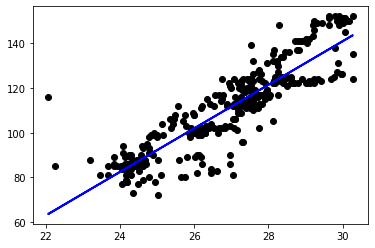

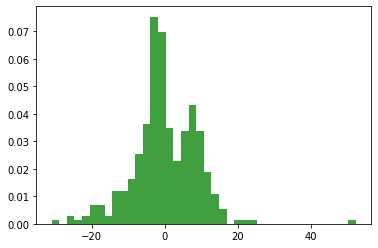

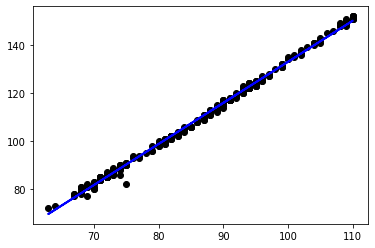

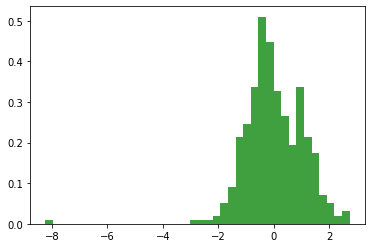

In [4]:
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import max_error, mean_squared_error
from sklearn.linear_model._base import LinearModel

import matplotlib.pyplot as plt


def validate_lin_reg(X_train: pd.DataFrame, y_train: pd.Series,
                     X_test: pd.DataFrame, y_test: pd.Series) -> LinearModel:
    # train
    alg: LinearRegression = LinearRegression().fit(X_train, y_train)

    # test
    y_predicted = alg.predict(X_test)

    print("Shape X_train/X_test: {}/{}".format(X_train.shape, X_test.shape))
    # Score on X_test
    print("Error R²: {:.2f}".format(alg.score(X_test, y_test)))
    mse = mean_squared_error(y_test.to_numpy(), y_predicted)
    print("MSE error (mean squared error / variance): {:.2f}".format(mse))
    print("sqrt(MSE) (standard deviation): {:.2f}".format(sqrt(mse)))
    print("Max error: {}".format(max_error(y_test, y_predicted)))

    # cross k-fold validation (k=5)
    scores: list = cross_val_score(alg, X_test.to_numpy(), y_test.to_numpy(), cv=5)
    print("Cross validation: {}".format(scores))
    return alg

def plot(estimator: LinearModel, X_train: pd.DataFrame, y_train: pd.Series) -> None:
    # Plot X_train -> y_train
    y_predicted = estimator.predict(X_train)
    plt.scatter(X_train, y_train,  color='black')
    plt.plot(X_train, y_predicted, color='blue', linewidth=2)
    plt.xticks()
    plt.yticks()
    plt.show()

    # Plot histogram of absolute error of |y_test - y_predicted|
    plt.hist(y_train - y_predicted, 40, density=True, facecolor='g', alpha=0.75)
    plt.show()
    plt.close()


# === Speed -> Power ===
X, y = dts_tacx.speed_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)
estimator: LinearModel = validate_lin_reg(X_train, y_train, X_test, y_test)
plot(estimator, X_train, y_train)

# === Cadence -> Power ===
X, y = dts_tacx.cadence_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)
estimator: LinearModel = validate_lin_reg(X_train, y_train, X_test, y_test)
plot(estimator, X_train, y_train)